# Haciendo clusters de tuits.

La primera parte es hacer extracción de temas. Utilicé tres métodos distintos para que hubiera cierta diferencia en la visualización, y elegí especificamente esos tres métodos por dos razones; son los recomendados para textos cortos como lo son los twits y estaban implementados en el módulo `sklearn`

In [1]:
from __future__ import print_function
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ggplot import *

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Tuve que aumentar el numero de palabras (features). Al principio pensé que sería 140 por la longitud de los twits pero más bien es el tamaño del lenguaje, habia tweets con solo ceros (en la matriz de aparicion de palabras), pues no contenía ninguna de las 140 palabras.

In [2]:
n_samples = 3005 #numero de twits
n_features = 2000 #tamaño del vocabulario
n_components = 15 #temas
n_top_words = 15 #variable para mostrar palabras
with open('twits.txt') as f:
    tweets = f.read().splitlines()
with open('stop_words.txt') as f:
    stop_words = f.read().splitlines()

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Tema #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
Elegí este valor para `min_df` para eliminar un poco las palabras que no aportaban significado. Si no está en treinta twits,
ignórala.

In [3]:
# Usa frecuencia de terminos para LDA.
print("Extrayendo frecuencia de terminos para LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.01,
                                max_features=n_features,
                                stop_words=stop_words)
t0 = time()
tf = tf_vectorizer.fit_transform(tweets)
print("Hecho en %0.3fs." % (time() - t0))
print()

Extrayendo frecuencia de terminos para LDA...
Hecho en 0.121s.



In [4]:
# Usa frecuencia de termino, frecuencia inversa en documento para NMF
print("Extrayendo caracteristicas tf-idf para NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=.01,
                                   max_features=n_features,
                                   stop_words=stop_words)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(tweets)
print("Hecho en %0.3fs." % (time() - t0))


Extrayendo caracteristicas tf-idf para NMF...
Hecho en 0.116s.


In [5]:
# Fit the NMF model
print("Ajustando el modelo NMF (Norma de Frobenius) con las caracteristicas tf-idf, "
      "muestras=%d and caracteristicas=%d..."
      % (n_samples, n_features))
t0 = time()
# Ajustando el modelo
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
# Transfora los datos de acuerto al modelo ajustado
ttd_nmf_f = nmf.transform(tfidf)

print("Hecho en %0.3fs." % (time() - t0))

print("\nTemas en el modelo NMF (Norma de Frobenius):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Ajustando el modelo NMF (Norma de Frobenius) con las caracteristicas tf-idf, muestras=3005 and caracteristicas=2000...
Hecho en 0.444s.

Temas en el modelo NMF (Norma de Frobenius):
Tema #0: otrousuario claro gran menos vaya creo siempre verdad mal bueno tener cosas vamos buena suerte
Tema #1: http link menos claro mal siempre verdad vida cosas estudiar vamos mundo bueno ganas buen
Tema #2: bien mañana voy dia vamos dormir ir vida siempre noche mal buena bueno eh gusta
Tema #3: si claro ver hacer buena mañana gran eh mal verdad tener lindo dia amo gusta
Tema #4: encanta estudiar casa dormir tener cosas vida noche eh verdad ver mundo lindo genial mal
Tema #5: 10 psuv extendieron colas gentío pm primarias link http casa estudiar día ganas genial gente
Tema #6: gracias hacer siempre vida verdad bueno buen amo dormir menos tener cosas noche ir dia
Tema #7: tan siempre tener cosas ganas buena vida mal casa bueno menos ver dia dormir mundo
Tema #8: jajaja mal voy ver amo eh ganas creo buen c

In [6]:
# Fit the NMF model
print("Ajustando el modelo NMF (divergencia de Kullback-Liebler generalizada) con las caracteristicas tf-idf, "
      "muestras=%d and caracteristicas=%d..."
      % (n_samples, n_features))
t0 = time()

# Ajustando el modelo
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
# Transfora los datos de acuerto al modelo ajustado
ttd_nmf_kl = nmf.transform(tfidf)

print("Hecho en %0.3fs." % (time() - t0))

print("\nTemas en el modelo NMF (divergencia de Kullback-Liebler generalizada):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Ajustando el modelo NMF (divergencia de Kullback-Liebler generalizada) con las caracteristicas tf-idf, muestras=3005 and caracteristicas=2000...
Hecho en 0.449s.

Temas en el modelo NMF (divergencia de Kullback-Liebler generalizada):
Tema #0: otrousuario claro eh dormir gran gracias gentío gente genial ganas extendieron estudiar encanta día voy
Tema #1: link http cosas voy día gracias gentío gente genial ganas extendieron estudiar encanta eh dormir
Tema #2: bien buen dormir siempre vamos vaya tan extendieron eh encanta estudiar voy ganas genial gente
Tema #3: si eh mal creo dormir claro hacer día gracias gentío gente genial ganas extendieron estudiar
Tema #4: encanta estudiar dormir genial mundo cosas siempre voy gracias gentío gente ganas extendieron eh día
Tema #5: psuv primarias pm gentío extendieron 10 colas dormir gracias gente genial ganas estudiar encanta eh
Tema #6: gracias cosas tan voy dormir gran gentío gente genial ganas extendieron estudiar encanta eh día
Tema #7: tan creo

In [7]:
print("Ajustando el moelo LDA con caracteristicas de frecuencia de terminos, "
      "muestras=%d and caracteristicas=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
# Ajustando el modelo
lda.fit(tf)
# Transfora los datos de acuerto al modelo ajustado
ttd_lda = lda.transform(tf)

print("Hecho en %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Ajustando el moelo LDA con caracteristicas de frecuencia de terminos, muestras=3005 and caracteristicas=2000...
Hecho en 3.644s.

Topics in LDA model:
Tema #0: ahora verdad cosas buen genial día otrousuario jajaja mejor creo claro voy gracias hoy mundo
Tema #1: otrousuario gracias claro amo jajaja si mejor vaya bueno día bien genial tan menos eh
Tema #2: si tan ver siempre amo gracias vida ganas día eh buena ahora casa cosas jajaja
Tema #3: 10 http link extendieron psuv primarias gentío pm colas otrousuario ahora si tener día tan
Tema #4: encanta tener casa vaya estudiar dormir mejor hace ganas menos voy http link dia ver
Tema #5: gente gusta otrousuario link http buen día vida si ahora bien jajaja hacer dormir encanta
Tema #6: dia lindo eh ir ahora día ver hacer hoy genial voy vamos dormir buen bien
Tema #7: mejor ir verdad bueno buena vida mundo claro gusta 10 ver hacer ganas vamos mañana
Tema #8: link http si mal ahora jajaja menos estudiar tan vaya buena claro otrousuario buen tene

El resultado de transformar los datos de acuerdo al modelo ajustado es un arreglo con la distribucion de los temas en cada muestra. Para etiquetar obtenemos el índice de dicho arreglo donde el valor sea máximo. En un experimento inicial
donde el número de características (palabras) era 140, había muestras que tenían la misma distribución para cada tema, pues no contenían ninguna palabra de las 140 seleccionadas. Partiendo de eso, elegí el número mil arbitrariamente porque no se me ocurrio una buena forma de establecer un mínimo. Podría buscar el twit más corto, quitarle las `stop_words` y dividir el total de twits entre la longitud resultante de dicho twit... pero no tengo forma de mostrar que ese procedimiento es más significativo que solo elegir mil.

In [8]:
y_nmf_f = np.argmax(ttd_nmf_f, axis=1)
y_lda = np.argmax(ttd_lda, axis=1)
y_nmf_kl = np.argmax(ttd_nmf_kl,axis=1)

Ahora que tenemos los twits en clusters, podemos considerar etiquetados los twits. Partiendo de esto podemos intentar visualizar.

El primer experimento será usando PCA, después con el misterioso t-SNE.

In [9]:
# DataFrame de pandas no acepta sparce_matrix de sk asi que lo convertimos
tf_arr = tf.toarray()
tfidf_arr = tfidf.toarray()

Como aclaración de la notación:
    LDA -> lda -> a veces sin notación explícita
    NMF (divergencia de Kullback-Liebler generalizada) -> nmfk -> a veces solo una k como subfijo
    NMF (norma de Frobenius) -> nmff -> a veces solo una f como subfijo
    

In [10]:
feat_cols_lda = [ 'word'+str(i) for i in range(tf_arr.shape[1]) ]
feat_cols_nmff = [ 'word'+str(i) for i in range(tfidf_arr.shape[1]) ]
feat_cols_nmfk = [ 'word'+str(i) for i in range(tfidf_arr.shape[1]) ]

df = pd.DataFrame(data=tf_arr,columns=feat_cols_lda)
df['label'] = y_lda
df['label'] = df['label'].apply(lambda i: str(i))

dff = pd.DataFrame(data=tfidf_arr,columns=feat_cols_nmff)
dff['label'] = y_nmf_f
dff['label'] = dff['label'].apply(lambda i: str(i))

dfk = pd.DataFrame(data=tfidf_arr,columns=feat_cols_nmfk)
dfk['label'] = y_nmf_kl
dfk['label'] = dfk['label'].apply(lambda i: str(i))

print('Forma del marco de datos para lda: {}'.format(df.shape))
print('Forma del marco de datos para nmff: {}'.format(dfk.shape))
print('Forma del marco de datos para nmfk: {}'.format(dff.shape))

Forma del marco de datos para lda: (3005, 56)
Forma del marco de datos para nmff: (3005, 56)
Forma del marco de datos para nmfk: (3005, 56)


In [11]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols_lda].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Variacion de los componentes principales para lda: {}'.format(pca.explained_variance_ratio_))

pcaf = PCA(n_components=3)
pcaf_result = pcaf.fit_transform(dff[feat_cols_nmff].values)

dff['pca-one'] = pcaf_result[:,0]
dff['pca-two'] = pcaf_result[:,1] 
dff['pca-three'] = pcaf_result[:,2]
print('Variacion de los componentes principales para nmff: {}'.format(pcaf.explained_variance_ratio_))

pcak = PCA(n_components=3)
pcak_result = pcak.fit_transform(dfk[feat_cols_nmfk].values)

dfk['pca-one'] = pcak_result[:,0]
dfk['pca-two'] = pcak_result[:,1] 
dfk['pca-three'] = pcak_result[:,2]
print('Variacion de los componentes principales para nmfk: {}'.format(pcak.explained_variance_ratio_))



Variacion de los componentes principales para lda: [ 0.22513684  0.18907581  0.07708231]
Variacion de los componentes principales para nmff: [ 0.1336674   0.10136345  0.04854808]
Variacion de los componentes principales para nmfk: [ 0.1336674   0.10136345  0.04854807]


En todos los casos la variación más grande se presenta en la suma de los dos primeros componentes, por lo tanto
esos son los que graficaremos.

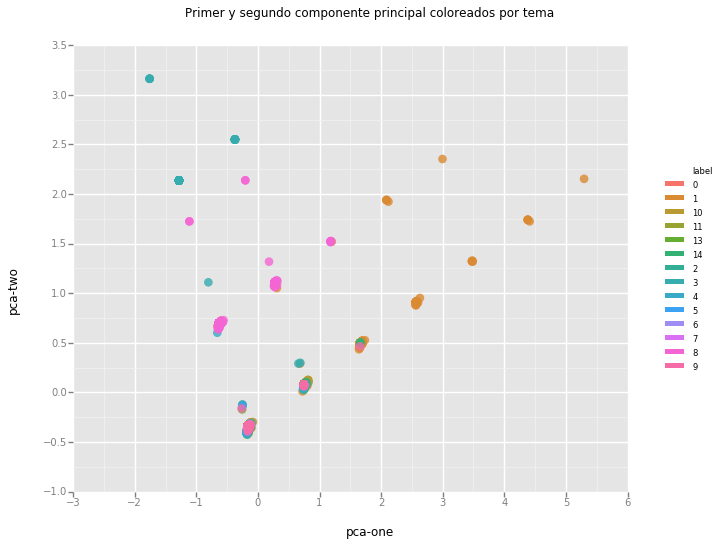

<ggplot: (-9223372036572531077)>

In [12]:
chart = ggplot( df, aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Primer y segundo componente principal coloreados por tema (LDA)")
chart

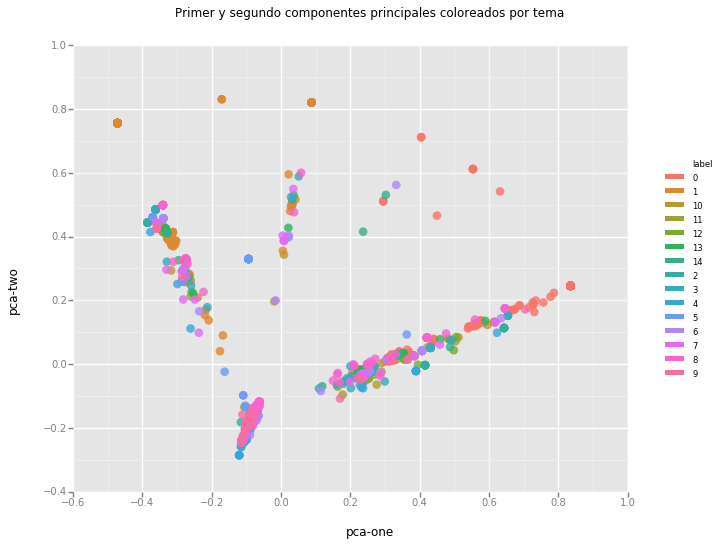

<ggplot: (281780025)>

In [13]:
chart = ggplot( dff, aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Primer y segundo componentes principales coloreados por tema (NMF-F)")
chart

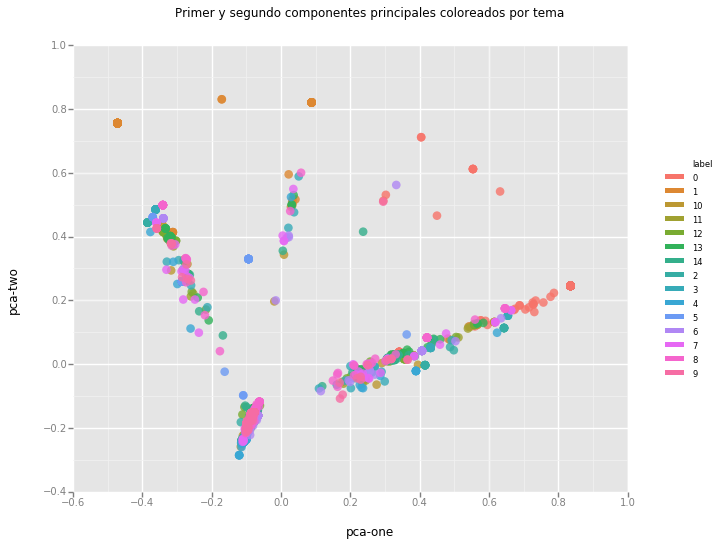

<ggplot: (-9223372036571312096)>

In [14]:
chart = ggplot( dfk, aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Primer y segundo componentes principales coloreados por tema (NMF-K)")
chart

¿Qué rayos es eso? ¿Es que acaso los temas no son ortogonales? ¿No son los componentes adecuados?
A ver con componentes distintos.

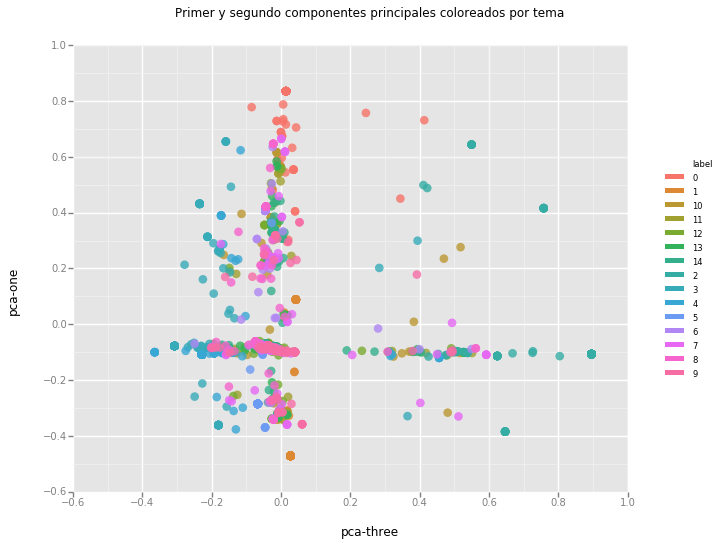

<ggplot: (284612616)>

In [15]:
chart = ggplot( dfk, aes(x='pca-three', y='pca-one', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Primer y segundo componentes principales coloreados por tema (NMF-K)")
chart

Este se ve mejor, pero aún así no se notan clusters significativos o bien separados.
Supongo que al ser en escencia proyecciones, pasan estas cosas raras. Entonces probemos otro.

#### T-Distributed Stochastic Neighbouring Entities (t-SNE)

In [16]:
n_sne = 3005

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(df.values)


print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3005 samples in 0.012s...
[t-SNE] Computed neighbors for 3005 samples in 0.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.871246
[t-SNE] Error after 300 iterations: 0.624436
t-SNE done! Time elapsed: 49.08516883850098 seconds


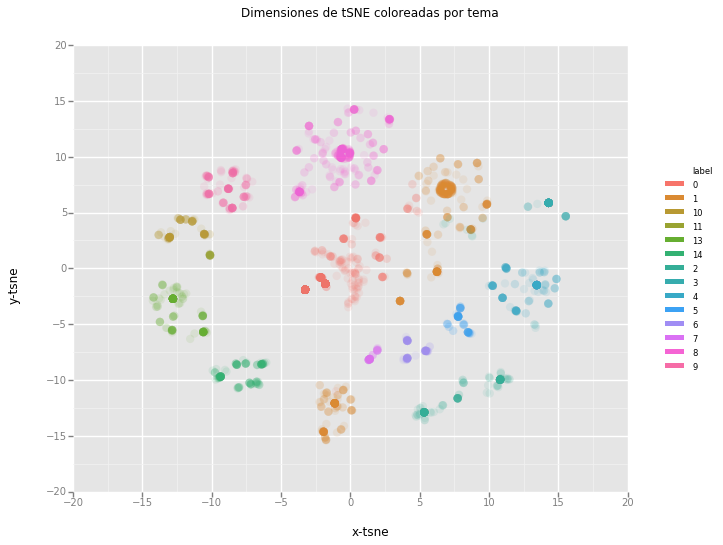

<ggplot: (-9223372036573949268)>

In [17]:
df_tsne = df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("Dimensiones de tSNE coloreadas por tema (LDA)")
chart

In [18]:
time_start = time()
tsnef = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_resultsf = tsnef.fit_transform(dff.values)


print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3005 samples in 0.011s...
[t-SNE] Computed neighbors for 3005 samples in 0.605s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.376575
[t-SNE] Error after 300 iterations: 0.692266
t-SNE done! Time elapsed: 48.200531005859375 seconds


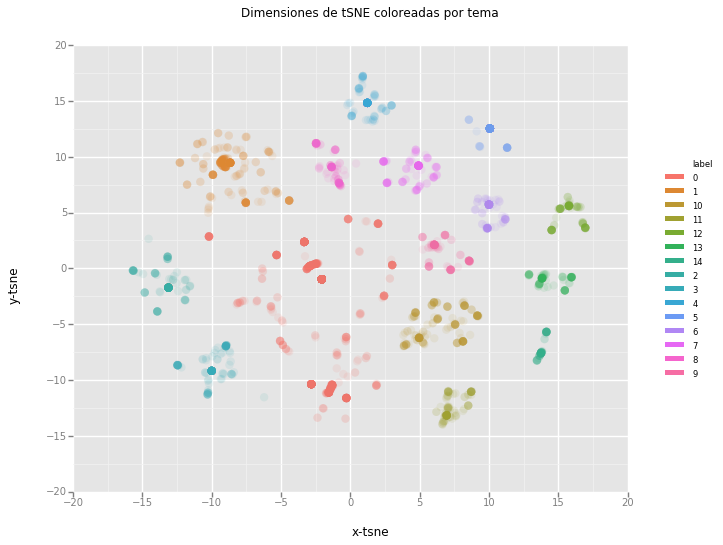

<ggplot: (281730056)>

In [19]:
dff_tsne = dff.copy()
dff_tsne['x-tsne'] = tsne_resultsf[:,0]
dff_tsne['y-tsne'] = tsne_resultsf[:,1]

chart = ggplot( dff_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("Dimensiones de tSNE coloreadas por tema (NMF-F)")
chart

In [20]:
time_start = time()
tsnek = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsnek_results = tsnek.fit_transform(dfk.values)


print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3005 samples in 0.011s...
[t-SNE] Computed neighbors for 3005 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.445316
[t-SNE] Error after 300 iterations: 0.632982
t-SNE done! Time elapsed: 43.10689902305603 seconds


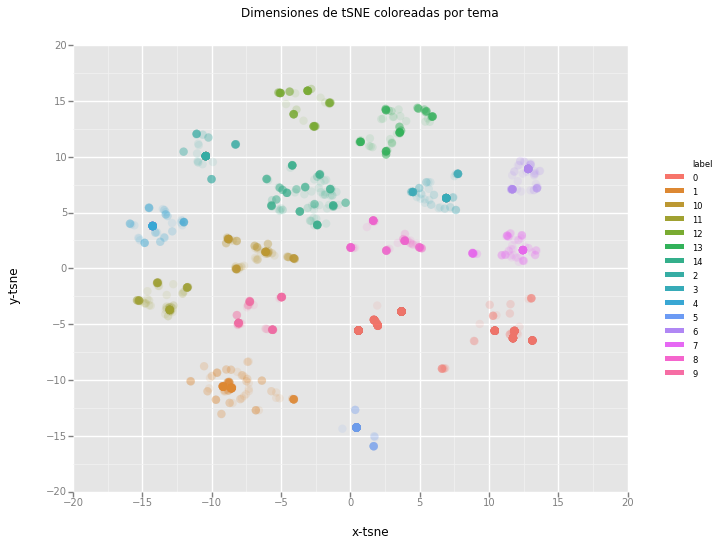

<ggplot: (-9223372036567497647)>

In [21]:
dfk_tsne = dfk.copy()
dfk_tsne['x-tsne'] = tsnek_results[:,0]
dfk_tsne['y-tsne'] = tsnek_results[:,1]

chart = ggplot( dfk_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("Dimensiones de tSNE coloreadas por tema (NMF-K)")
chart